### data2a - 120416_0229
* re-run, trying regularization

### data2a - 120116_1200
* run with cleaned dataset, just on damage location, 256x256, ft 8 batch size, 88s per epoch, theano backend
* saved history, created metrics plots
* noted that rmsprop results in higher top layer accuracy for initial fit - closer to 70%
* loss: 0.6640 - acc: 0.7273 - val_loss: 0.5893 - val_acc: 0.7836

### data2 - 112916_1200
* run without discards, just on damage location 256x256, 16 batch size, 80s per epoch, theano backend
* loss: 0.6776 - acc: 0.7151 - val_loss: 0.7998 - val_acc: 0.6928

In [11]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

# only import if using tf backend
# import tensorflow as tf
# tf.python.control_flow_ops = tf

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled)


In [3]:
def load_vgg16(crop=True, weights_path='../vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
      
    # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 

        f = h5py.File(weights_path)
        for k in range(f.attrs['nb_layers']):
            if k >= len(model.layers): 
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [4]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16(crop=True)
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, # reduced batch size to 16
                                            class_mode=None, 
                                            shuffle=False) 
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [8]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch]

In [6]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print "Best Model:" 
    print_best_model_results(hist)

In [7]:
# load saved data and train a small, fully-connected model
def train_categorical_model():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax')) # upped to 3 and activation softmax

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
    
    # optimizer='rmsprop'
    # optimizers.SGD(lr=0.0001, momentum=0.9)
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')


    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [8]:
def finetune_categorical_model():
    # Build the VGG16 Network (again)
    model = load_vgg16(crop=True)

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False


    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                        samples_per_epoch=nb_train_samples,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=nb_validation_samples,
                        verbose=1,
                        callbacks=[checkpoint])
    
    with open(location+'/history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [9]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True);

In [10]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Inputs

In [17]:
# path to the model weights file
location = 'data2a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [9]:
d2_model, d2_history = train_categorical_model()

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 0s - loss: 8.2361 - acc: 0.3790 - val_loss: 3.2459 - val_acc: 0.4737
Epoch 2/50
979/979 [==============================] - 0s - loss: 4.0510 - acc: 0.5036 - val_loss: 2.0990 - val_acc: 0.3801
Epoch 3/50
979/979 [==============================] - 0s - loss: 1.0761 - acc: 0.6057 - val_loss: 2.4129 - val_acc: 0.3743
Epoch 4/50
979/979 [==============================] - 0s - loss: 1.0999 - acc: 0.6006 - val_loss: 2.6318 - val_acc: 0.3216
Epoch 5/50
979/979 [==============================] - 0s - loss: 0.8163 - acc: 0.6813 - val_loss: 0.8916 - val_acc: 0.5965
Epoch 6/50
979/979 [==============================] - 0s - loss: 0.6970 - acc: 0.7160 - val_loss: 0.9802 - val_acc: 0.6433
Epoch 7/50
979/979 [==============================] - 0s - loss: 0.5789 - acc: 0.7824 - val_loss: 1.0198 - val_acc: 0.6608
Epoch 8/50
979/979 [==============================] - 0s - loss: 0.5670 - acc: 0.7978 - val_l

In [9]:
ft_d2_model, ft_d2_history = finetune_v2_model()

Model with partial VGG16 weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
979/979 [==============================] - 89s - loss: 1.7468 - acc: 0.5506 - val_loss: 0.9886 - val_acc: 0.6901
Epoch 2/50
979/979 [==============================] - 88s - loss: 1.1734 - acc: 0.5352 - val_loss: 0.7967 - val_acc: 0.6433
Epoch 3/50
979/979 [==============================] - 88s - loss: 1.0206 - acc: 0.5781 - val_loss: 0.8533 - val_acc: 0.6491
Epoch 4/50
979/979 [==============================] - 89s - loss: 0.9206 - acc: 0.6108 - val_loss: 0.8348 - val_acc: 0.6959
Epoch 5/50
979/979 [==============================] - 89s - loss: 0.9411 - acc: 0.5873 - val_loss: 0.8414 - val_acc: 0.7251
Epoch 6/50
979/979 [==============================] - 88s - loss: 0.9164 - acc: 0.5955 - val_loss: 0.8988 - val_acc: 0.6316
Epoch 7/50
979/979 [==============================] - 88s - loss: 0.8667 - acc: 0.6251 - val_loss: 0.8640 - val_acc: 0.6257
Epoch 8/5

Try:
* more aggresive data augmentation
* more aggressive dropout
* use of L1 and L2 regularization (also known as "weight decay")
* fine-tuning one more convolutional block (alongside greater regularization)
* use  LR reduce callback
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

### Second Run - With Regularization

In [21]:
# do not rerun!!
save_bottleneck_features(location)

VGG16 Model with partial weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [27]:
d2_model, d2_history = train_categorical_model()

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 1s - loss: 6.2939 - acc: 0.3953 - val_loss: 1.0766 - val_acc: 0.4094
Epoch 2/50
979/979 [==============================] - 1s - loss: 6.1112 - acc: 0.4617 - val_loss: 1.0198 - val_acc: 0.5029
Epoch 3/50
979/979 [==============================] - 1s - loss: 6.0435 - acc: 0.4872 - val_loss: 0.9771 - val_acc: 0.5263
Epoch 4/50
979/979 [==============================] - 1s - loss: 5.9937 - acc: 0.5424 - val_loss: 0.9365 - val_acc: 0.5848
Epoch 5/50
979/979 [==============================] - 1s - loss: 5.9480 - acc: 0.5516 - val_loss: 0.9359 - val_acc: 0.5614
Epoch 6/50
979/979 [==============================] - 1s - loss: 5.8981 - acc: 0.5781 - val_loss: 0.8882 - val_acc: 0.5848
Epoch 7/50
979/979 [==============================] - 1s - loss: 5.8375 - acc: 0.6415 - val_loss: 0.9010 - val_acc: 0.5614
Epoch 8/50
979/979 [==============================] - 1s - loss: 5.8162 - acc: 0.6394 - val_l

In [30]:
ft_d2_model, ft_d2_history = finetune_categorical_model()

VGG16 Model with partial weights loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
979/979 [==============================] - 91s - loss: 5.4254 - acc: 0.5924 - val_loss: 0.7412 - val_acc: 0.7135
Epoch 2/50
979/979 [==============================] - 90s - loss: 5.4000 - acc: 0.5996 - val_loss: 0.7712 - val_acc: 0.6725
Epoch 3/50
979/979 [==============================] - 91s - loss: 5.4052 - acc: 0.5945 - val_loss: 0.7053 - val_acc: 0.7368
Epoch 4/50
979/979 [==============================] - 90s - loss: 5.3884 - acc: 0.6098 - val_loss: 0.7445 - val_acc: 0.6901
Epoch 5/50
979/979 [==============================] - 90s - loss: 5.3741 - acc: 0.6292 - val_loss: 0.7265 - val_acc: 0.7193
Epoch 6/50
979/979 [==============================] - 90s - loss: 5.3745 - acc: 0.6170 - val_loss: 0.7773 - val_acc: 0.6667
Epoch 7/50
979/979 [==============================] - 90s - loss: 5.3720 - acc: 0.6037 - val_loss: 0.7027 - val_acc: 0.7251
Epoch 8/5

## Model evaluation

### First Run - Without Regularization

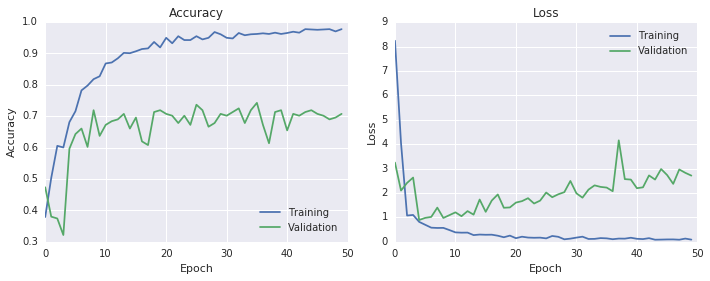

In [10]:
plot_metrics(d2_history)

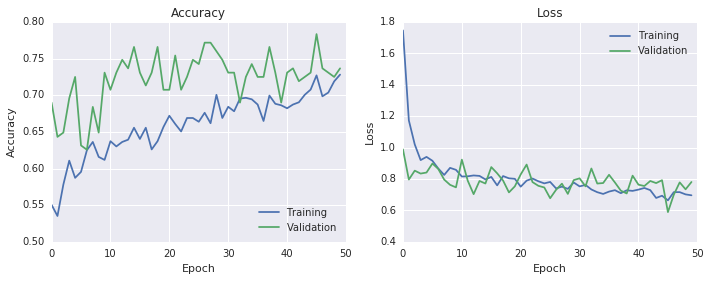

In [11]:
plot_metrics(ft_d2_history)

## Second Run - Metrics

Best Model:
epoch: 47 , val_acc: 0.719298247008 , val_loss: 0.749537965708


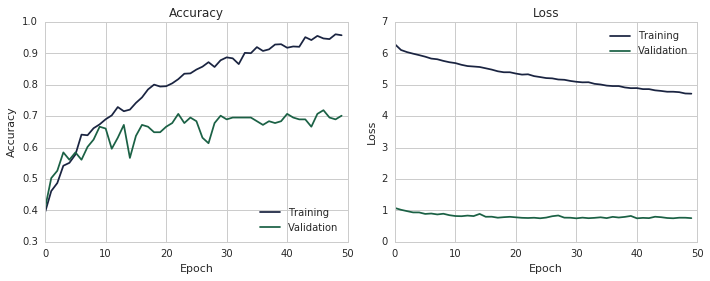

In [28]:
plot_metrics(d2_history)

Best Model:
epoch: 30 , val_acc: 0.789473684211 , val_loss: 0.635747588692


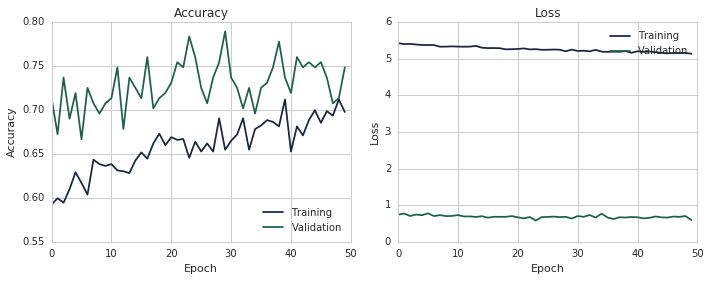

In [31]:
plot_metrics(ft_d2_history)

You can then use keras.models.load_model(filepath) to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [3]:
ft_d2_model2 = load_model('data2a/ft_d2_model.h5')

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.77      0.86      0.81        73
          1       0.73      0.66      0.69        50
          2       0.75      0.69      0.72        48

avg / total       0.75      0.75      0.75       171




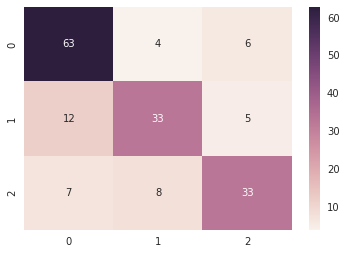

In [56]:
evaluate_model(ft_d2_model, validation_data_dir, validation_labels)

# Load Model Point

In [20]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print "Best Model:" 
    print_best_model_results(hist)

In [12]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [13]:
ft_model = load_model('data2a/ft_model.h5')

In [15]:
with open('data2a/top_history.txt') as f:    
    top_history = json.load(f)

In [16]:
with open('data2a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [20]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [21]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.77      0.79      0.78        73
          1       0.74      0.70      0.72        50
          2       0.76      0.77      0.76        48

avg / total       0.76      0.76      0.76       171




In [28]:
with open('data3_1/top_history.txt') as f:    
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

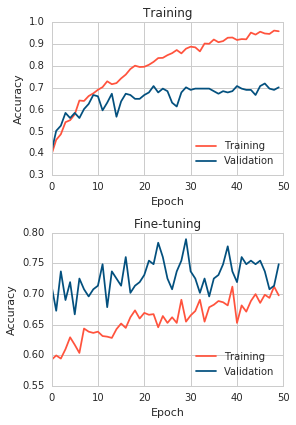

In [29]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 47 , val_acc: 0.719298247008 , val_loss: 0.749537965708


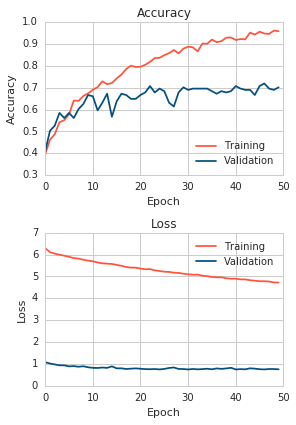

In [21]:
plot_metrics(top_history)

Best Model:
epoch: 30 , val_acc: 0.789473684211 , val_loss: 0.635747588692


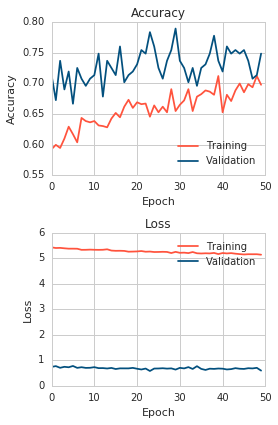

In [12]:
plot_metrics(ft_history)

In [23]:
heatmap_labels = ['Front', 'Rear', 'Side']

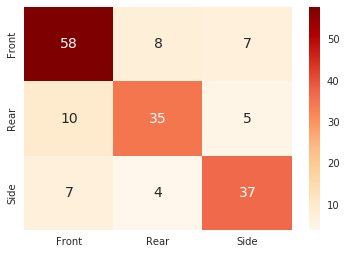

In [36]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

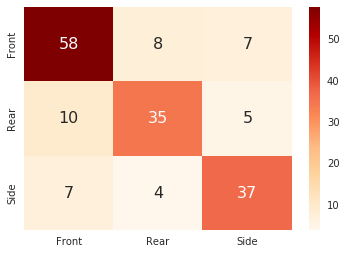

In [24]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

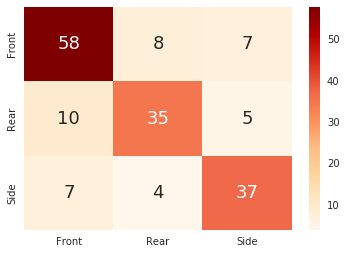

In [25]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

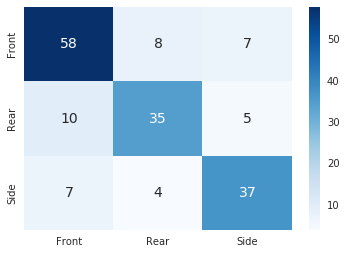

In [41]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

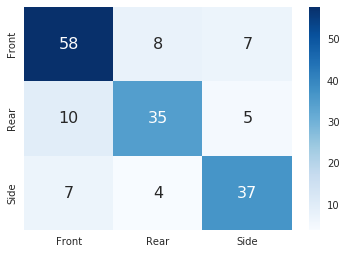

In [26]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

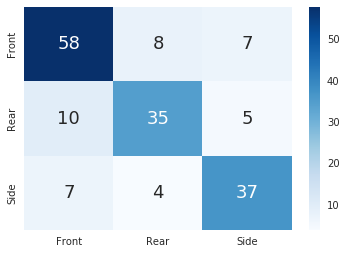

In [27]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Looking at Edge Cases

In [36]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [39]:
front1 = get_edge_cases(ft_model, 'data2a/validation/00-front/', 0, 1) # true front, predicted rear - 8
front2 = get_edge_cases(ft_model, 'data2a/validation/00-front/', 0, 2) # true front, predicted side - 7

In [40]:
rear1 = get_edge_cases(ft_model, 'data2a/validation/01-rear/', 1, 0) # true rear, predicted front - 10
rear2 = get_edge_cases(ft_model, 'data2a/validation/01-rear/', 1, 2) # true rear, predicted side - 5

In [41]:
side1 = get_edge_cases(ft_model, 'data2a/validation/02-side/', 2, 0) # true side, predicted front - 7
side2 = get_edge_cases(ft_model, 'data2a/validation/02-side/', 2, 1) # true side, predicted rear - 4

In [43]:
len(front1) == 8, len(front2) == 7, len(rear1) == 10, len(rear2) == 5, len(side1) == 7, len(side2) == 4

(True, True, True, True, True, True)

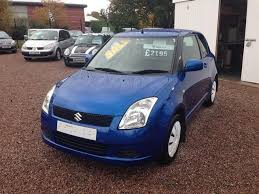

c to continue, q to quitc


In [44]:
view_images('data2a/validation/00-front/', front1)

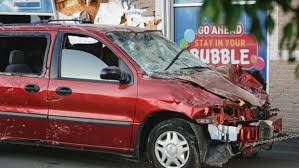

c to continue, q to quitc


In [45]:
view_images('data2a/validation/00-front/', front2)

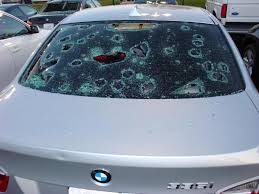

c to continue, q to quitc


In [47]:
view_images('data2a/validation/01-rear/', rear1)

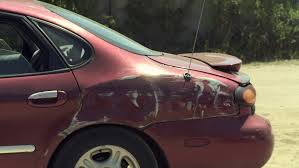

c to continue, q to quitc


In [48]:
view_images('data2a/validation/01-rear/', rear2)

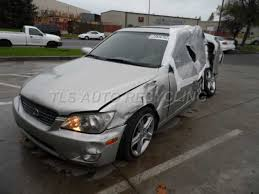

c to continue, q to quitc


In [50]:
view_images('data2a/validation/02-side/', side1)

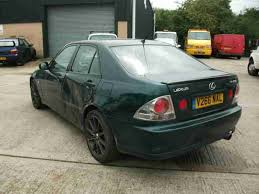

c to continue, q to quitc


In [53]:
view_images('data2a/validation/02-side/', side2)

https://keras.io/visualization/

Couldn't import dot_parser, loading of dot files will not be possible.


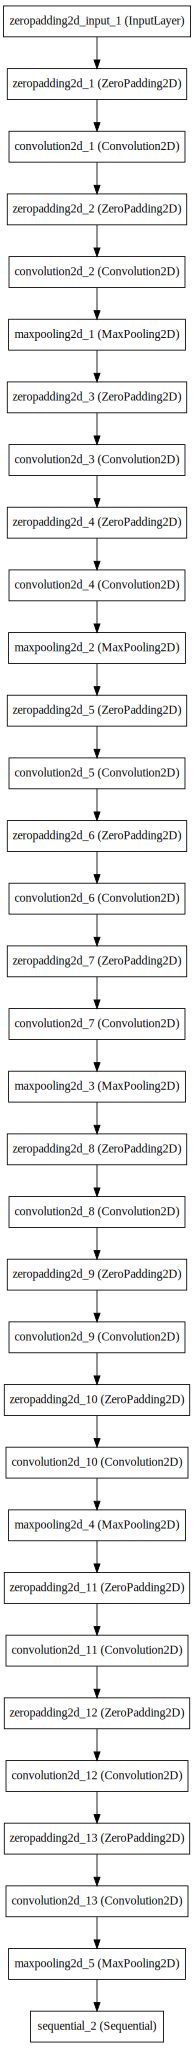

In [5]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(ft_d2_model2).create(prog='dot', format='svg'))